 # Préambule

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os 
import warnings
warnings.filterwarnings("ignore") 

import string #pour avoir la liste des characteres spéciaux
import bz2 #lecture fichiers compressés


import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle as pkl
import re

import nltk    #Natural language processing tool-kit
nltk.download('stopwords')
from nltk.corpus import stopwords

from wordcloud import WordCloud
from PIL import Image

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score



# Lecture des données

In [0]:
my_path= "/content/drive/My Drive"


In [0]:
train = bz2.BZ2File(my_path +'/train.ft.txt.bz2','r')
test = bz2.BZ2File(my_path + '/test.ft.txt.bz2','r')

# Pré-processing

On sépare le fichiers texte en paragraphe, chaque paragraphe contient le label, le review et un retour à la ligne.

In [0]:
train_lines = train.readlines()
test_lines = test.readlines()

In [0]:
print("La taille du train est :",len(train_lines),"\n") 
print("La taille du test est:",len(test_lines),"\n")

La taille du train est : 3600000 

La taille du test est: 400000 



## Split des données

La description des données indique qu'il existe 2 labels: 1 pour les mauvais commentaires et 2 pour les bons.
On crée un tableau à 2 colonnes: la première contient les commentaires, la deuxièmes les labels.

In [0]:
def splitMissyData(data): #data de la forme readlines()
    tab = []
    for i in range(len(data)):
        text = str(data[i]) # on stock chaque commentaire dans la var text tenstypée en string
        missyLabel = text[0:11] # les char contennat l'info sur le label est stocké dans missyLabel
        if '1' in missyLabel:  # on crée un label propre contennant 0 (pour 1) ou 1 (pour 2) 
            label = 0
        elif '2' in missyLabel:
            label = 1
        review = str(text[11:])
        review = review[:-2] # on enlève le 'n' du '\n' présent à la fin de chaque commentaire
        tab.append([review,label]) # on ajoute chaque commentaire avec son  label dans un tab
    return tab

## Passage aux miniscules

In [0]:
def minuscules(data):
    tab = []
    for i in range(len(data)):
        tab.append(str(data[i]).lower())
    return tab
        

## Detection et suppression des url

In [0]:
def remove_url(data):
  tab = []
  for i in range(len(data)):
    if 'www.' in data[i] or 'http:' in data[i] or 'https:' in data[i] or '.com' in data[i] :
        text_noURL = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "", data[i])
    else:
      text_noURL = data[i]
    tab.append(text_noURL)
  return tab

## Caractères spéciaux

On enlève les caracteres spéciaux avec la fonction $maketrans(arg_1,arg_2)$.
Si un des caracteres de $arg_1$ est trouvé dans notre chaîne de caractères on le remplace par le caractere de $arg_2$ situé à la même place que le caractére trouvé dans a$rg_1$: $arg_1$ et $arg_2$ douvent donc avoir la même longueur.

In [0]:
def remove_SpecChar(data): #data de la forme d'une liste
    specChar = string.punctuation #string contenant les caractères spéciaux 
    replaceBy = " "*len(specChar) #strig composée d'espaces de la même taille qu specChar: chaque cacatère spécial
    tab = []
    for i in range(len(data)):
        text = str(data[i])
        text_noSpecChar = str.maketrans(specChar,replaceBy)
        tab.append(text.translate(text_noSpecChar))
    return tab #retourne une colonne de type liste contenant les reviews sans caracteres spéciaux

## Accents

In [0]:
def trans_accent(data): 
    tab = []
    for i in range(len(data)):
        text_noAccent = str.maketrans('àéèêëïî','aeeeeii')
        tab.append(data[i].translate(text_noAccent))
    return tab
        

## Fonction finale de pre-processing (encapsulation de ce qui précède)

In [0]:
def preProc(data):
    # Séparation des reviews et labels et transformation en dataframe
    missyData_df = pd.DataFrame(splitMissyData(data),columns=['missyReviews','Label'])
    
    #On crée une nouvelle colonne au dataframe contanant les revies que l'on va nettoyer
    # Minuscules
    missyData_df['Reviews'] = minuscules(missyData_df['missyReviews'])
    #URL
    missyData_df['Reviews'] = remove_url(missyData_df['Reviews'])
    #Caractères spéciaux
    missyData_df['Reviews'] = remove_SpecChar(missyData_df['Reviews'])
    #Accents
    missyData_df['Reviews'] = trans_accent(missyData_df['Reviews'])

    
    # On crée un nouveau dataframe contenant les review et les labls propres
    CleanData = pd.DataFrame()
    CleanData['Reviews'] = missyData_df['Reviews']
    CleanData['Label'] = missyData_df['Label']
    return CleanData
        

# Application du pré-processing aux données du train et du test


## UTF-8 et préprocessing


In [0]:
train_lines = [x.decode('utf-8') for x in train_lines]
test_lines = [x.decode('utf-8') for x in test_lines]

In [0]:
train_preprocess = preProc(train_lines)
test_preprocess = preProc(test_lines)

# Class Balancing

Text(0.5, 1.0, 'Class Balancing - Train')

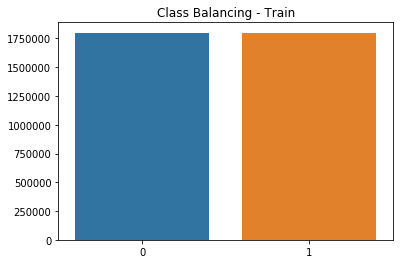

In [0]:
sns.barplot(np.unique(train_df['Label']),train_df.groupby('Label').count().values[:,0]).set_title('Class Balancing - Train')

Text(0.5, 1.0, 'Class Balancing - Test')

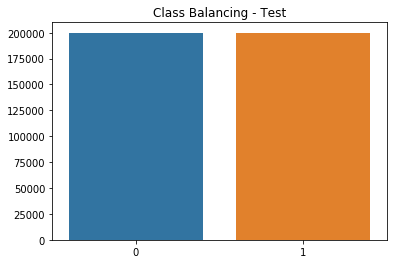

In [0]:
sns.barplot(np.unique(test_df['Label']),test_df.groupby('Label').count().values[:,0]).set_title('Class Balancing - Test')

# Nombre total de mots 


In [0]:
def count_words(data):
  nbr_words = 0
  for i in range(len(data)):
    nbr_words = nbr_words + len(str(data[i]).split())
  return nbr_words
  

In [0]:
nbr_words_train = count_words(train_df['Reviews'])
nbr_words_train

In [0]:
nbr_words_test = count_words(test_df['Reviews'])
nbr_words_test

#Bag of words

On regarde les 200 000 premières lignes du train (pour la rapidité des calculs).

In [0]:
X_part = train_df['Reviews'][0:200000]

Création  du dictionnaire puis on compte le nombre d'apparition de chaque mot constituant le dictionnaire dans chaque commentaire. Sachant le nombre très élevé de mots, on va se restreindre à prendre tout les mots apparaissant plus de 0.1% et moins de 95%. Ceci nous permettra d'éliminer ainsi toute les fautes de frappe.

---



In [0]:
count_vec = CountVectorizer(max_df=0.95, min_df=0.0010, max_features=None)

count_train_part = count_vec.fit(X_part)
X_counts_part = count_vec.fit_transform(X_part)
dictionnary_part= count_vec.get_feature_names()



On affiche l'ensemble des mots du dictionnaire apparaissant plus de 0.1% et moins de 95%. On affiche aussi la taille du dictonnaire.

In [0]:
print(dictionnary_part)
print(len(dictionnary_part))

['00', '000', '10', '100', '1000', '11', '12', '13', '14', '15', '150', '16', '17', '18', '19', '1970', '1980', '1984', '1999', '19th', '1st', '20', '200', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '20th', '21', '22', '23', '24', '25', '28', '2nd', '30', '300', '35', '3d', '3rd', '40', '400', '45', '4th', '50', '500', '5th', '60', '600', '60s', '6th', '70', '70s', '75', '80', '800', '80s', '90', '90s', '95', '98', '99', 'abilities', 'ability', 'able', 'about', 'above', 'absolute', 'absolutely', 'absurd', 'abuse', 'ac', 'academic', 'academy', 'accent', 'accept', 'acceptable', 'access', 'accessible', 'accident', 'accidentally', 'accomplished', 'according', 'account', 'accounts', 'accuracy', 'accurate', 'accurately', 'achieve', 'acoustic', 'across', 'act', 'acted', 'acting', 'action', 'actions', 'active', 'activities', 'actor', 'actors', 'actress', 'acts', 'actual', 'actually', 'ad', 'adam', 'adaptation', 'adapter', 'add', 'added', 'adding', '

On définit la fonction most_frequent_words qui nous permet de créer le dictionnaire et d'afficher le diagramme en baton des mots les plus présents avec leur nombre d'apparition. 

In [0]:
def most_frequent_words(count_vect,data): 
  
    # matrice renseignant sur les mots de chaque commentaire avec la valeur qui leur est associé et leur nombre de répetion dans le commantaire  
    data_counts = count_vect.fit_transform(data) 
    dictionary   = count_vect.get_feature_names() # tableau contenant l'ensemble des mots du dictionnaire
    print("Taille du dictionnaire : ",len(dictionary)) # affiche la taille du dictionnaire
    
    word_counts = pd.DataFrame(data_counts.toarray(),columns = dictionary)
    # séparation des données : numero commentaire en ligne  , mot du dictionnaire en colonne 
    #il y a donc 3 600 000 de lignes et n nombre de colonnes (avec n = taille du dictonnaire)
    word_total_counts = pd.DataFrame()
    word_total_counts['count'] = word_counts.sum(axis=0)
    #compte le nombre d'appartion de chaque mot du dictonnaire
    word_total_counts['word'] = dictionary
    word_total_counts_sorted_top  = word_total_counts.sort_values(by="count",ascending = False).iloc[0:20]
    #affiche les 20 mots les plus presents et leur nombre d'apparition 
    plt.figure(figsize=(15,8))
    sns.barplot(x = word_total_counts_sorted_top.index,y=word_total_counts_sorted_top['count'])
    plt.xticks(rotation=90,fontsize=10)
    plt.show()
    return {'data_counts' : data_counts, 'word_total_counts' :word_total_counts, 'dictionary' : dictionary}
    # On affiche un diagramme en baton avec les 20 mots les plus présents en abscisse et leur nombre en ordonnée 
    

On visualise le diagramme en baton associé au dictionnaire créé.

Taille du dictionnaire :  4530


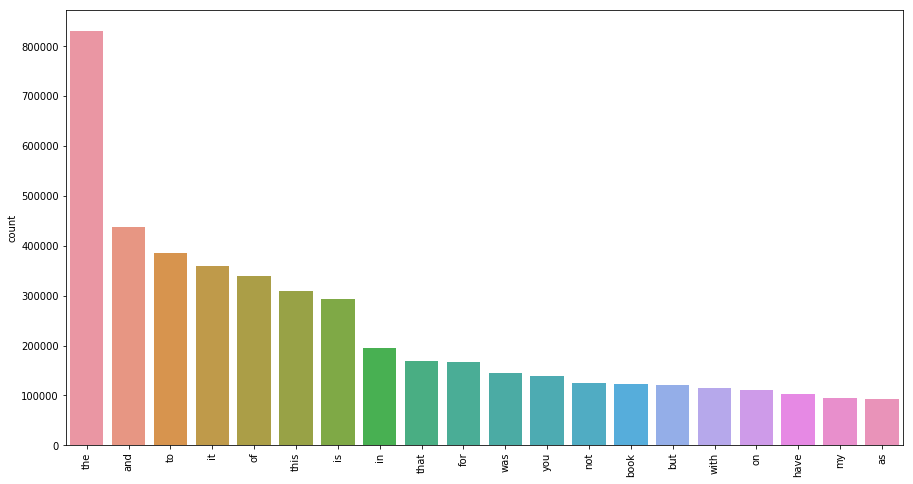

In [0]:
most_frequent_words_train_part = most_frequent_words(count_vec,X_part)

On se donne une liste de stop-words.

In [0]:
stop = set(stopwords.words('english')) 
print(stop)
print(len(stop))

{'at', 'against', 'you', 'did', 'themselves', 'this', 'very', 'couldn', 'where', 'their', 'yourselves', 'other', 'being', 'do', 'wasn', 'were', 'doing', 'her', 'for', 'to', 'nor', 're', "you've", 'if', 'our', 'having', 'some', 's', 'once', 'himself', 'm', 'but', "hadn't", 've', 'with', 'while', "haven't", "should've", 'those', 'had', 'ours', 'hasn', "won't", 'does', 'shan', "wasn't", 'what', 'won', 'by', 'above', 'more', 'or', 'few', 'ourselves', "hasn't", 'his', 'both', 'through', 'each', 'here', 'most', 'from', 'has', 'which', 'again', 'any', 'haven', 'all', 'and', 'that', 'who', 'because', 'then', 'mightn', 'he', 'yourself', 'have', 'these', 'under', 'after', 'll', 'needn', 'no', 'too', 'below', 'yours', 'when', 'been', 'over', 't', 'ma', "that'll", 'was', "don't", 'now', 'of', 'so', 'they', 'i', 'only', "needn't", "aren't", 'further', 'up', 'why', 'my', 'o', 'an', 'am', "didn't", "doesn't", 'down', 'weren', 'in', 'aren', 'theirs', 'myself', 'hers', 'same', 'd', "shan't", "wouldn't"

On enlève les stop-words du dictionnaire que l'on a créé précédemment.

In [0]:
count_vec = CountVectorizer(stop_words = stop, max_df=0.95, min_df=0.0010, max_features=None)

count_train_part_sw = count_vec.fit(X_part)
#X_counts_part_sw = count_vec.fit_transform(X_part)
dictionnary_part_sw= count_vec.get_feature_names()

On affiche les mots du dictionnaire en ayant enlevé les stop-words

In [0]:
print(dictionnary_part_sw)
print(len(dictionnary_part_sw))

['00', '000', '10', '100', '1000', '11', '12', '13', '14', '15', '150', '16', '17', '18', '19', '1970', '1980', '1984', '1999', '19th', '1st', '20', '200', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '20th', '21', '22', '23', '24', '25', '28', '2nd', '30', '300', '35', '3d', '3rd', '40', '400', '45', '4th', '50', '500', '5th', '60', '600', '60s', '6th', '70', '70s', '75', '80', '800', '80s', '90', '90s', '95', '98', '99', 'abilities', 'ability', 'able', 'absolute', 'absolutely', 'absurd', 'abuse', 'ac', 'academic', 'academy', 'accent', 'accept', 'acceptable', 'access', 'accessible', 'accident', 'accidentally', 'accomplished', 'according', 'account', 'accounts', 'accuracy', 'accurate', 'accurately', 'achieve', 'acoustic', 'across', 'act', 'acted', 'acting', 'action', 'actions', 'active', 'activities', 'actor', 'actors', 'actress', 'acts', 'actual', 'actually', 'ad', 'adam', 'adaptation', 'adapter', 'add', 'added', 'adding', 'addition', 'additi

Taille du dictionnaire :  4392


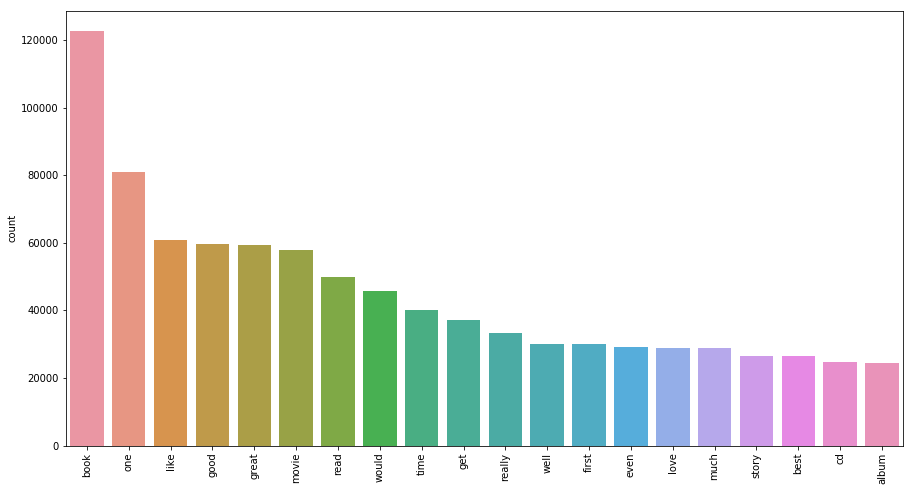

In [0]:
most_frequent_words_train_part_sw1 = most_frequent_words(count_vec,X_part)

On ajoute "book" , "movie" et "one" aux stop-words.

In [0]:
stop.update({'movie','book','one'})

On visualise le nouveau diagramme en baton en ayant enlevé les stop-words et les mots 'book' , 'movie' et 'one'.

Taille du dictionnaire :  4389


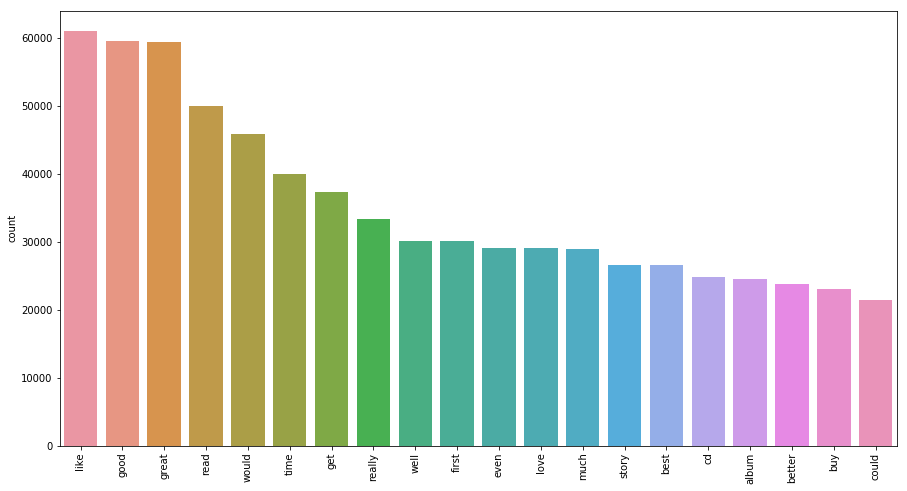

In [0]:
count_vec = CountVectorizer(stop_words = stop, max_df=0.95, min_df=0.0010, max_features=None)
X_counts= count_vec.fit_transform(X_part)
most_frequent_words_train_sw = most_frequent_words(count_vec,X_part)

In [0]:
word_counts_train = pd.DataFrame(X_counts.toarray(),columns = count_vec.get_feature_names())
word_total_counts_train = pd.DataFrame()
word_total_counts_train['count'] = word_counts_train.sum(axis=0)

On va afficher les mots constituant le dictionnaire en fonction de leur fréquence d'apparition.

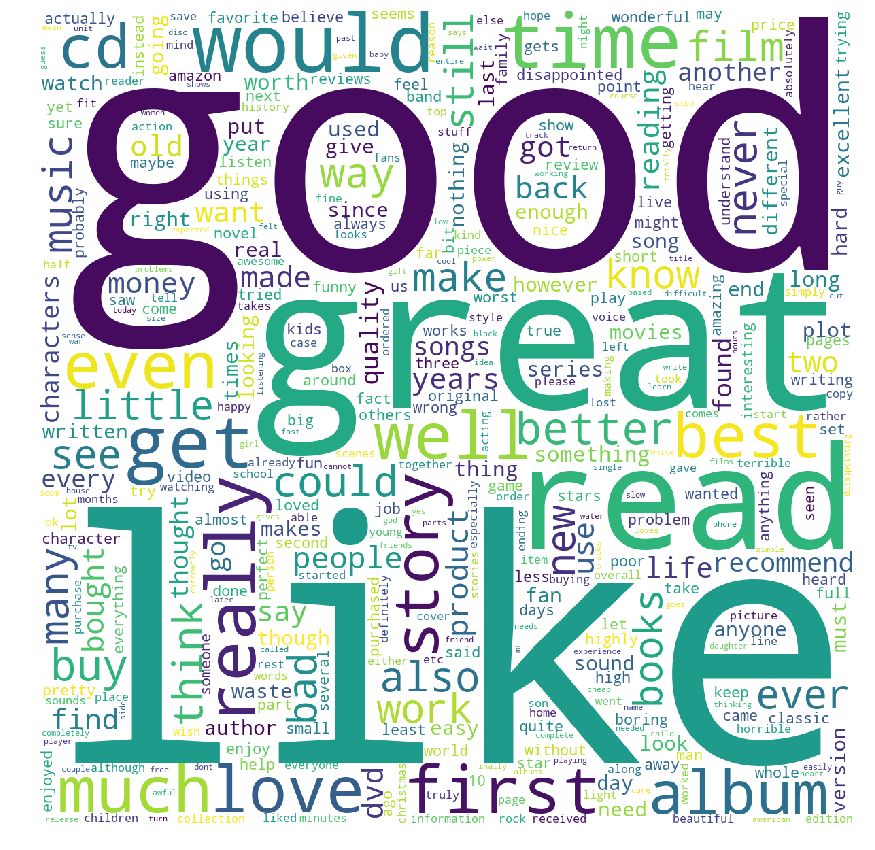

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

plt.rcParams['figure.figsize'] = (15, 15)
wordcloud_train = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 400, random_state=42).generate_from_frequencies(word_total_counts_train['count'])
plt.imshow(wordcloud_train)
plt.axis('off')
plt.show()

On refait la même chose pour le train cette fois-ci.

In [0]:
Y = test_df['Reviews'][0:70000]

Taille du dictionnaire :  4379


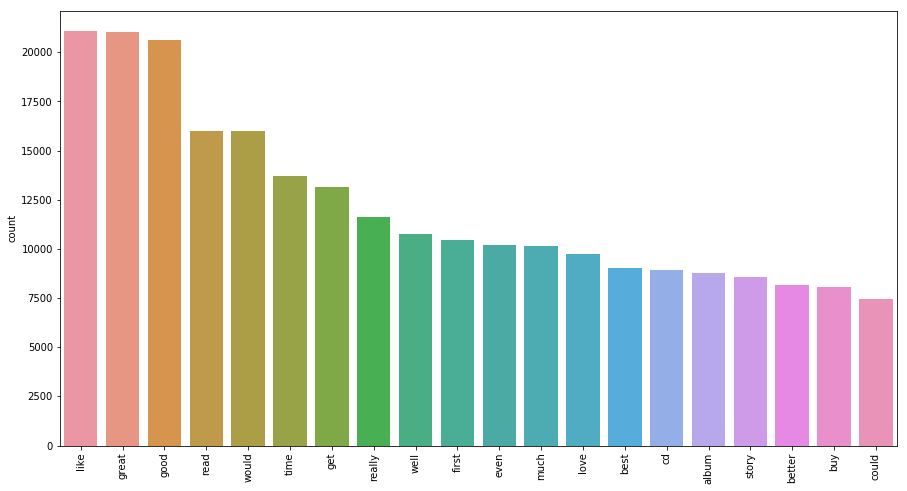

In [0]:
count_vec = CountVectorizer(stop_words = stop, max_df=0.95, min_df=0.0010, max_features=None)
Y_counts= count_vec.fit_transform(Y)
most_frequent_words_test = most_frequent_words(count_vec,Y)

In [0]:
word_counts_test = pd.DataFrame(Y_counts.toarray(),columns = count_vec.get_feature_names())
word_total_counts_test = pd.DataFrame()
word_total_counts_test['count'] = word_counts_test.sum(axis=0)

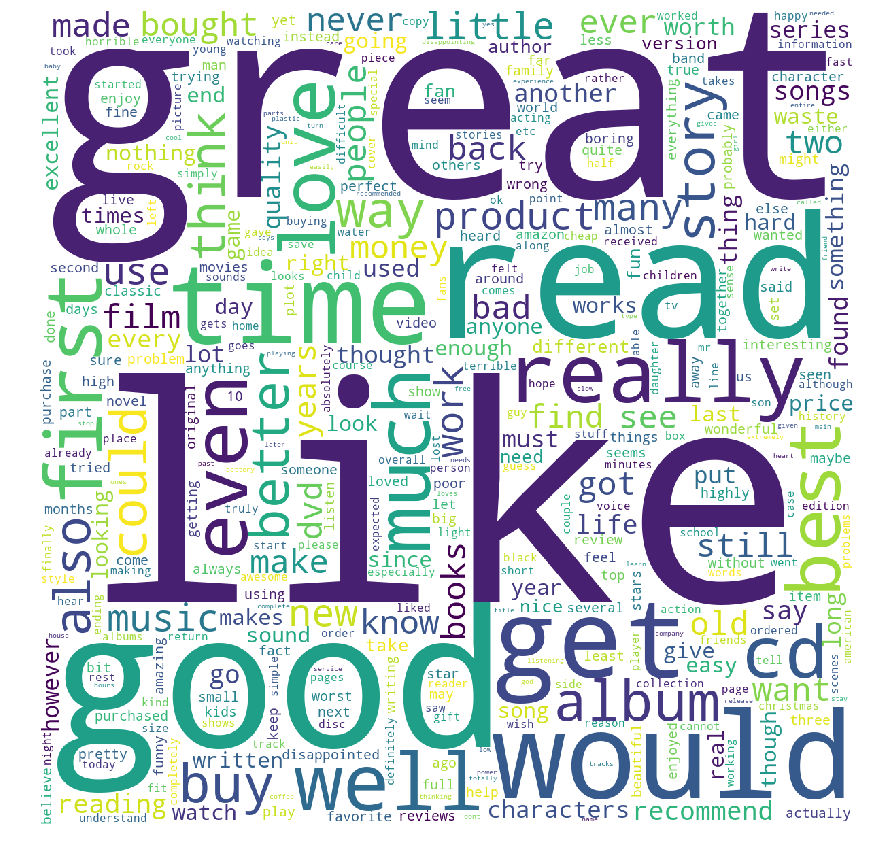

In [0]:

plt.rcParams['figure.figsize'] = (15, 15)
wordcloud_test = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 400, random_state=42).generate_from_frequencies(word_total_counts_test['count'])
plt.imshow(wordcloud_test)
plt.axis('off')
plt.show()


In [0]:
amazon = np.array(Image.open("/content/drive/My Drive/logo-amazon1.jpg"))

In [0]:
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 21.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

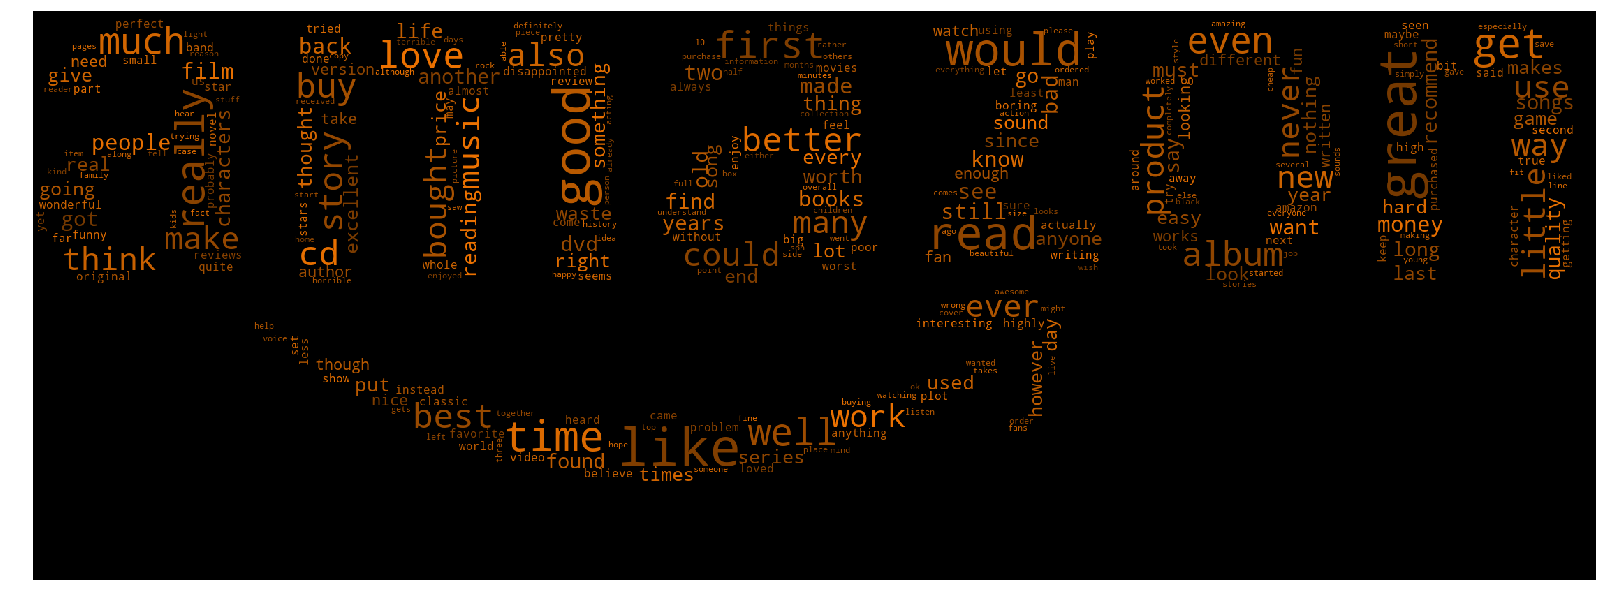

In [0]:
plt.rcParams['figure.figsize'] = (28, 28)
wordcloud = WordCloud(background_color = 'black', collocations=False, width = 2000,  height = 2000,mask = amazon , max_words = 300, color_func=random_color_func ,random_state=42).generate_from_frequencies(word_total_counts_test['count'])
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Apprentissage supervisé

## Sur les counts

### Première approche des algorithmes

In [0]:
N_train = 200000 #max testé sans crash kernel : 200000 
N_test = 70000 #66% train 34% test

X_train = train_preprocess['Reviews'][0:N_train]
X_test = test_preprocess['Reviews'][0:N_test]

y_train = train_preprocess['Label'][0:N_train]
y_test = test_preprocess['Label'][0:N_test]

In [0]:
count_vect = CountVectorizer(stop_words="english", analyzer='word', max_df=0.95, min_df=0.0010, max_features=None)
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test) 

dictionary = count_vect.get_feature_names()

In [0]:
mNB = MultinomialNB().fit(X=X_train, y=y_train)
accuracy_score(mNB.predict(X_test), y_test)

0.8434

In [0]:
# On se limite aux 100.000 premiers commentaires car si trop de données, crash du kernel
lda = LinearDiscriminantAnalysis().fit(X=X_train[0:100000,:].toarray(), y=y_train[0:100000])
print('fitted')
accuracy_score(lda.predict(X_test), y_test)

fitted


0.8709428571428571

In [0]:
# On se limite aux 100.000 premiers commentaires car si trop de données, crash du kernel
qda = QuadraticDiscriminantAnalysis().fit(X=X_train[0:100000,:].toarray(), y=y_train[0:100000])
print('fitted')
accuracy_score(qda.predict(X_test.toarray()), y_test)

fitted
0.7833571428571429


In [0]:
svm = SGDClassifier().fit(X=X_train.toarray(), y=y_train)
accuracy_score(svm.predict(X_test), y_test)

0.8799428571428571

In [0]:
log = SGDClassifier(loss='log').fit(X=X_train.toarray(), y=y_train)
accuracy_score(log.predict(X_test), y_test)

0.8787142857142857

In [0]:
tree = DecisionTreeClassifier().fit(X=X_train.toarray(), y=y_train)
accuracy_score(tree.predict(X_test), y_test)

0.7630142857142858

In [0]:
rf = RandomForestClassifier().fit(X=X_train.toarray(), y=y_train)
accuracy_score(rf.predict(X_test), y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8194428571428571

In [0]:
acc_scores_counts = [0.8434, 0.8709428571428571, 0.7833571428571429, 0.8799428571428571, 0.8787142857142857, 0.7630142857142858, 0.8194428571428571] 

In [0]:
names = ['Naive Bayes', 'LDA /!\ ', 'QDA /!\ ', 'SVM', 'Logistic Regression',
         'Decision Tree', 'Random Forest']
names_acc = [] #liste de tuple qui va servir à associer à chaque modèle, son score 
for i in range(len(names)):
    names_acc.append((names[i], acc_scores_counts[i]))
    
names_acc.sort(key=lambda names_acc:names_acc[1], reverse=True) #on ordonne la liste par importance du score de precision

In [0]:
print('Première approche: counts')
for i, n in enumerate(names_acc):
    print(i+1, '-',n[0], ("%.5f" % n[1]))

Première approche: counts
1 - SVM 0.87994
2 - Logistic Regression 0.87871
3 - LDA /!\  0.87094
4 - Naive Bayes 0.84340
5 - Random Forest 0.81944
6 - QDA /!\  0.78336
7 - Decision Tree 0.76301


Les premiers modèles utilisés ne permettent pas de trancher en faveur d'un l'algorithme plus adapté à nos données.

## Sur TF-IDF

In [0]:
transformer = TfidfTransformer(smooth_idf=False)

In [0]:
train_tf_idf = transformer.fit_transform(X_train)
test_tf_idf = transformer.transform(X_test)

### Première approche des algorithmes

In [0]:
gNB = GaussianNB().fit(X=train_tf_idf.toarray(), y=y_train)
accuracy_score(gNB.predict(test_tf_idf.toarray()), y_test)

0.7908428571428572


In [0]:
# On se limite aux 100.000 premiers commentaires car si trop de données, crash du kernel
lda = LinearDiscriminantAnalysis().fit(X=train_tf_idf[0:100000,:].toarray(), y=y_train[0:100000])
accuracy_score(lda.predict(test_tf_idf.toarray()), y_test)

0.8714857142857143

In [0]:
# On se limite aux 100.000 premiers commentaires car si trop de données, crash du kernel
qda = QuadraticDiscriminantAnalysis().fit(X=train_tf_idf[0:100000,:].toarray(), y=y_train[0:100000])
print('fitted')
accuracy_score(qda.predict(test_tf_idf.toarray()), y_test)

fitted


0.7853142857142857

In [0]:
svm = SGDClassifier().fit(X=train_tf_idf.toarray(), y=y_train)
accuracy_score(svm.predict(test_tf_idf.toarray()), y_test)

0.8755857142857143

In [0]:
log = SGDClassifier(loss='log').fit(X=train_tf_idf.toarray(), y=y_train)
accuracy_score(log.predict(test_tf_idf.toarray()), y_test)

0.8678285714285714

In [0]:
tree = DecisionTreeClassifier().fit(X=train_tf_idf.toarray(), y=y_train)
accuracy_score(tree.predict(test_tf_idf.toarray()), y_test)

0.7553428571428571

In [0]:
rf = RandomForestClassifier().fit(X=train_tf_idf.toarray(), y=y_train)
accuracy_score(rf.predict(test_tf_idf.toarray()), y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8202428571428572

In [0]:
acc_scores_tfidf = [0.7908428571428572, 0.8714857142857143, 0.7853142857142857, 0.8755857142857143, 0.8678285714285714, 0.7553428571428571, 0.8202428571428572] 

In [0]:
names = ['Naive Bayes', 'LDA /!\ ', 'QDA /!\ ', 'SVM', 'Logistic Regression',
         'Decision Tree', 'Random Forest']
names_acc = [] #liste de tuple qui va servir à associer à chaque modèle, son score 
for i in range(len(names)):
    names_acc.append((names[i], acc_scores_tfidf[i]))
    
names_acc.sort(key=lambda names_acc:names_acc[1], reverse=True) #on ordonne la liste par importance du score de precision

In [0]:
print('Première approche: tf-idf')
for i, n in enumerate(names_acc):
    print(i+1, '-',n[0], ("%.5f" % n[1]))

Première approche: tf-idf
1 - SVM 0.87559
2 - LDA /!\  0.87149
3 - Logistic Regression 0.86783
4 - Random Forest 0.82024
5 - Naive Bayes 0.79084
6 - QDA /!\  0.78531
7 - Decision Tree 0.75534


### Selection des algorthimes et cross-validation

### Cross-validation SVM

In [0]:
l1_ratios = [x/10 for x in range(11)]
cv_svm_train = []
cv_svm_test = []
print('Cross validation - SVM')
for l in l1_ratios:
  print('l1_ratio = ', l, end=' ... ')
  clf = SGDClassifier(loss='hinge', penalty='elasticnet', l1_ratio=l)
  clf.fit(X=train_tf_idf.toarray(), y=y_train)
  acs_train = accuracy_score(clf.predict(train_tf_idf.toarray()), y_train)
  acs_test = accuracy_score(clf.predict(test_tf_idf.toarray()), y_test)
  cv_svm_train.append(acs_train)
  cv_svm_test.append(acs_test)
  print('done! ')

Cross validation - SVM
l1_ratio =  0.0 ... done! 
l1_ratio =  0.1 ... done! 
l1_ratio =  0.2 ... done! 
l1_ratio =  0.3 ... done! 
l1_ratio =  0.4 ... done! 
l1_ratio =  0.5 ... done! 
l1_ratio =  0.6 ... done! 
l1_ratio =  0.7 ... done! 
l1_ratio =  0.8 ... done! 
l1_ratio =  0.9 ... done! 
l1_ratio =  1.0 ... done! 


In [0]:
print(cv_svm_train)
print(cv_svm_test)

[0.88196, 0.881095, 0.87994, 0.87799, 0.87587, 0.875245, 0.873305, 0.87161, 0.869325, 0.868025, 0.86566]
[0.8752, 0.8754142857142857, 0.8739285714285714, 0.8730285714285714, 0.8719714285714286, 0.8710571428571429, 0.8698428571428571, 0.8681, 0.8662428571428571, 0.8635714285714285, 0.8619857142857142]


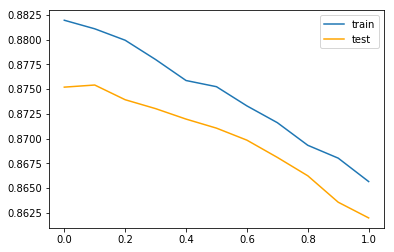

In [0]:
plt.plot(l1_ratios, cv_svm_train, label='train')
plt.plot(l1_ratios, cv_svm_test, color='orange', label='test')
plt.legend()

La meilleure précision obtenue est pour l1_ratio=0.1, nous allons affiner la recherche pour l1_ratio compris entre 0 et 0.2 afin de mieux déterminer la valeur optimale de l1_ratio.

In [0]:
l1_ratios = [x/100 for x in range(21)]
cv_svm_train_2 = []
cv_svm_test_2 = []
print('Cross validation - SVM')
for l in l1_ratios:
  print('l1_ratio = ', l, end=' ... ')
  clf = SGDClassifier(loss='hinge', penalty='elasticnet', l1_ratio=l)
  clf.fit(X=train_tf_idf.toarray(), y=y_train)
  acs_train = accuracy_score(clf.predict(train_tf_idf.toarray()), y_train)
  acs_test = accuracy_score(clf.predict(test_tf_idf.toarray()), y_test)
  cv_svm_train_2.append(acs_train)
  cv_svm_test_2.append(acs_test)
  print('done! ')

Cross validation - SVM
l1_ratio =  0.0 ... done! 
l1_ratio =  0.01 ... done! 
l1_ratio =  0.02 ... done! 
l1_ratio =  0.03 ... done! 
l1_ratio =  0.04 ... done! 
l1_ratio =  0.05 ... done! 
l1_ratio =  0.06 ... done! 
l1_ratio =  0.07 ... done! 
l1_ratio =  0.08 ... done! 
l1_ratio =  0.09 ... done! 
l1_ratio =  0.1 ... done! 
l1_ratio =  0.11 ... done! 
l1_ratio =  0.12 ... done! 
l1_ratio =  0.13 ... done! 
l1_ratio =  0.14 ... done! 
l1_ratio =  0.15 ... done! 
l1_ratio =  0.16 ... done! 
l1_ratio =  0.17 ... done! 
l1_ratio =  0.18 ... done! 
l1_ratio =  0.19 ... done! 
l1_ratio =  0.2 ... done! 


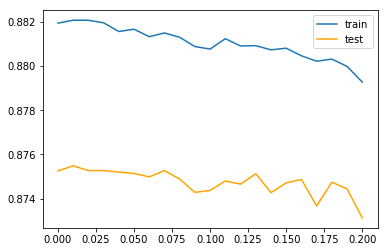

In [0]:
plt.plot(l1_ratios, cv_svm_train_2, label='train')
plt.plot(l1_ratios, cv_svm_test_2, color='orange', label='test')
plt.legend()

La meilleure précision obtenue est très proche de l1_ratio=0, c'est à dire une pénalisation proche de celle de Ridge.

### Cross-validation Regression Logistique

In [0]:
l1_ratios = [x/10 for x in range(11)]
cv_log_train = []
cv_log_test = []
print('Cross validation - Régression Logistique')
for l in l1_ratios:
  print('l1_ratio = ', l, end=' ... ')
  clf = SGDClassifier(loss='log', penalty='elasticnet', l1_ratio=l)
  clf.fit(X=train_tf_idf.toarray(), y=y_train)
  acs_train = accuracy_score(clf.predict(train_tf_idf.toarray()), y_train)
  acs_test = accuracy_score(clf.predict(test_tf_idf.toarray()), y_test)
  cv_log_train.append(acs_train)
  cv_log_test.append(acs_test)
  print('done! ')

Cross validation - Régression Logistique
l1_ratio =  0.0 ... done! 
l1_ratio =  0.1 ... done! 
l1_ratio =  0.2 ... done! 
l1_ratio =  0.3 ... done! 
l1_ratio =  0.4 ... done! 
l1_ratio =  0.5 ... done! 
l1_ratio =  0.6 ... done! 
l1_ratio =  0.7 ... done! 
l1_ratio =  0.8 ... done! 
l1_ratio =  0.9 ... done! 
l1_ratio =  1.0 ... done! 


In [0]:
print(cv_log_train)
print(cv_log_test)

[0.872975, 0.870675, 0.867835, 0.865525, 0.86332, 0.86098, 0.858935, 0.85725, 0.855405, 0.853315, 0.84997]
[0.8683714285714286, 0.8662142857142857, 0.8638142857142858, 0.8624714285714286, 0.8604857142857143, 0.8584714285714286, 0.8570428571428571, 0.8550857142857143, 0.8533714285714286, 0.8514142857142857, 0.8476571428571429]


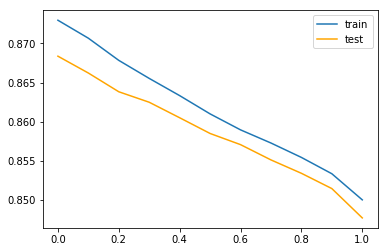

In [0]:
plt.plot(l1_ratios, cv_log_train, label='train')
plt.plot(l1_ratios, cv_log_test, color='orange', label='test')
plt.legend()

Comme pour l'algorithme précédent, la meilleure précision est obtenue pour l1_ratio=0.

### Cross validation Arbre de classification

In [0]:
max_depth = [x for x in range(3,15)]
cv_tree_train = []
cv_tree_test = []
print('Cross validation - Arbre de Décision')
for d in max_depth:
  print('max_depth = ', d, end=' ... ')
  clf = DecisionTreeClassifier(max_depth=d)
  clf.fit(X=train_tf_idf.toarray(), y=y_train)
  acs_train = accuracy_score(clf.predict(train_tf_idf.toarray()), y_train)
  acs_test = accuracy_score(clf.predict(test_tf_idf.toarray()), y_test)
  cv_tree_train.append(acs_train)
  cv_tree_test.append(acs_test)
  print('done! ')

Cross validation - Arbre de Décision
max_depth =  3 ... done! 
max_depth =  4 ... done! 
max_depth =  5 ... done! 
max_depth =  6 ... done! 
max_depth =  7 ... done! 
max_depth =  8 ... done! 
max_depth =  9 ... done! 
max_depth =  10 ... done! 
max_depth =  11 ... done! 
max_depth =  12 ... done! 
max_depth =  13 ... done! 
max_depth =  14 ... done! 


In [0]:
print(cv_tree_train)
print(cv_tree_test)

[0.62603, 0.648845, 0.67505, 0.67813, 0.681975, 0.68525, 0.68831, 0.690505, 0.702085, 0.718725, 0.72147, 0.730485, 0.73937, 0.747865, 0.75561, 0.763435, 0.77159, 0.77722, 0.78037, 0.7872, 0.793275, 0.796505, 0.80283, 0.807845, 0.813235, 0.816175, 0.81958, 0.82258, 0.825745, 0.83017, 0.83287, 0.83563, 0.83813, 0.842455, 0.845945, 0.84954, 0.852625]
[0.6286142857142857, 0.6518, 0.6777, 0.6796142857142857, 0.6817428571428571, 0.6841142857142857, 0.6867428571428571, 0.6880857142857143, 0.6982142857142857, 0.7145, 0.7151285714285714, 0.7220714285714286, 0.7290428571428571, 0.7360714285714286, 0.7410142857142857, 0.7456, 0.7509714285714286, 0.7542, 0.755, 0.7580714285714286, 0.7602857142857142, 0.7595571428571428, 0.7633285714285715, 0.7641285714285714, 0.7661714285714286, 0.7672285714285715, 0.7664714285714286, 0.7663, 0.7655571428571428, 0.7670142857142858, 0.7664285714285715, 0.7663142857142857, 0.7658571428571429, 0.7668714285714285, 0.7667714285714285, 0.7680428571428571, 0.767328571428

In [0]:
#cv_tree_train = [0.62603, 0.648845, 0.67505, 0.67813, 0.681975, 0.68525, 0.68831, 0.690505, 0.702085, 0.718725, 0.72147, 0.730485, 0.73937, 0.747865, 0.75561, 0.763435, 0.77159, 0.77722, 0.78037, 0.7872, 0.793275, 0.796505, 0.80283, 0.807845, 0.813235, 0.816175, 0.81958, 0.82258, 0.825745, 0.83017, 0.83287, 0.83563, 0.83813, 0.842455, 0.845945, 0.84954, 0.852625]
#cv_tree_test = [0.6286142857142857, 0.6518, 0.6777, 0.6796142857142857, 0.6817428571428571, 0.6841142857142857, 0.6867428571428571, 0.6880857142857143, 0.6982142857142857, 0.7145, 0.7151285714285714, 0.7220714285714286, 0.7290428571428571, 0.7360714285714286, 0.7410142857142857, 0.7456, 0.7509714285714286, 0.7542, 0.755, 0.7580714285714286, 0.7602857142857142, 0.7595571428571428, 0.7633285714285715, 0.7641285714285714, 0.7661714285714286, 0.7672285714285715, 0.7664714285714286, 0.7663, 0.7655571428571428, 0.7670142857142858, 0.7664285714285715, 0.7663142857142857, 0.7658571428571429, 0.7668714285714285, 0.7667714285714285, 0.7680428571428571, 0.7673285714285715]

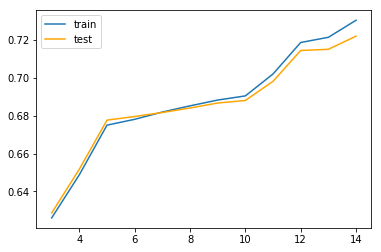

In [0]:
plt.plot(max_depth, cv_tree_train, label='train')
plt.plot(max_depth, cv_tree_test, color='orange', label='test')
plt.legend()

Les profondeurs maximales choisies ne semblent pas être optimale, les deux courbes continuent d'augmenter.

In [0]:
max_depth = [x for x in range(15,40)]
print('Cross validation - Arbre de Décision')
for d in max_depth:
  print('max_depth = ', d, end=' ... ')
  clf = DecisionTreeClassifier(max_depth=d)
  clf.fit(X=train_tf_idf.toarray(), y=y_train)
  acs_train = accuracy_score(clf.predict(train_tf_idf.toarray()), y_train)
  acs_test = accuracy_score(clf.predict(test_tf_idf.toarray()), y_test)
  cv_tree_train.append(acs_train)
  cv_tree_test.append(acs_test)
  print('done! ')

Cross validation - Arbre de Décision
max_depth =  15 ... done! 
max_depth =  16 ... done! 
max_depth =  17 ... done! 
max_depth =  18 ... done! 
max_depth =  19 ... done! 
max_depth =  20 ... done! 
max_depth =  21 ... done! 
max_depth =  22 ... done! 
max_depth =  23 ... done! 
max_depth =  24 ... done! 
max_depth =  25 ... done! 
max_depth =  26 ... done! 
max_depth =  27 ... done! 
max_depth =  28 ... done! 
max_depth =  29 ... done! 
max_depth =  30 ... done! 
max_depth =  31 ... done! 
max_depth =  32 ... done! 
max_depth =  33 ... done! 
max_depth =  34 ... done! 
max_depth =  35 ... done! 
max_depth =  36 ... done! 
max_depth =  37 ... done! 
max_depth =  38 ... done! 
max_depth =  39 ... done! 


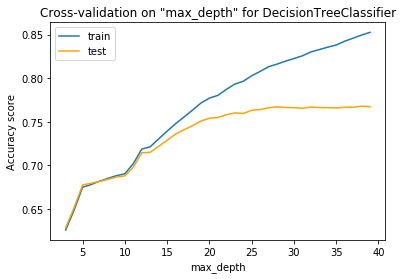

In [0]:
max_depth = [x for x in range(3,40)]
plt.plot(max_depth, cv_tree_train, label='train')
plt.plot(max_depth, cv_tree_test, color='orange', label='test')
plt.title('Cross-validation on "max_depth" for DecisionTreeClassifier')
plt.xlabel('max_depth')
plt.ylabel('Accuracy score')
plt.legend()

On n'observe toujours pas la redescente de la courbe test, synonyme de sur-apprentissage, on ne peut donc toujours pas décider quelle est la profondeur optimale de notre arbre de décision.

In [0]:
max_depth = [x for x in range(40,46)]
print('Cross validation - Arbre de Décision')
for d in max_depth:
  print('max_depth = ', d, end=' ... ')
  clf = DecisionTreeClassifier(max_depth=d)
  clf.fit(X=train_tf_idf.toarray(), y=y_train)
  acs_train = accuracy_score(clf.predict(train_tf_idf.toarray()), y_train)
  acs_test = accuracy_score(clf.predict(test_tf_idf.toarray()), y_test)
  cv_tree_train.append(acs_train)
  cv_tree_test.append(acs_test)
  print('done! ')

Cross validation - Arbre de Décision
max_depth =  40 ... done! 
max_depth =  41 ... done! 
max_depth =  42 ... done! 
max_depth =  43 ... done! 
max_depth =  44 ... done! 
max_depth =  45 ... done! 


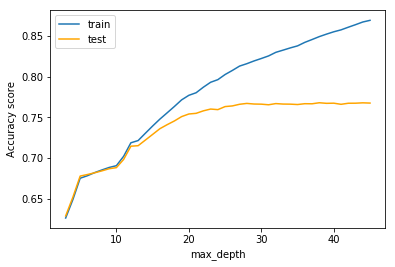

In [0]:
max_depth = [x for x in range(3,46)]
plt.plot(max_depth, cv_tree_train, label='train')
plt.plot(max_depth, cv_tree_test, color='orange', label='test')
plt.title('Cross-validation on "max_depth" for DecisionTreeClassifier')
plt.xlabel('max_depth')
plt.ylabel('Accuracy score')
plt.legend()

Les profondeurs appliquées sont beaucoup trop grande pour obtenir des résultats avec rapidité. De plus, le score de précision sur le test reste toujours moins bon qu'avec SVM et Regression Logistique.

## Roc curve and confusion matrix

In [0]:
### SGDClassifier

In [0]:
svm = SGDClassifier(loss='hinge', penalty='elasticnet', l1_ratio=0.01).fit(X=train_tf_idf.toarray(), y=y_train)
y_score_svm = svm.decision_function(test_tf_idf.toarray())
y_pred_svm = svm.predict(test_tf_idf.toarray())

In [0]:
log = SGDClassifier(loss='log', penalty='elasticnet', l1_ratio=0.0).fit(X=train_tf_idf.toarray(), y=y_train)
y_score_log = log.decision_function(test_tf_idf.toarray())
y_pred_log = log.predict(test_tf_idf.toarray())

In [0]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for svm
fpr_svm = dict()
tpr_svm = dict()
roc_auc_svm = dict()

fpr_svm, tpr_svm, thr_svm = roc_curve(y_test, y_score_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Compute ROC curve and ROC area for log
fpr_log = dict()
tpr_log = dict()
roc_auc_log = dict()

fpr_log, tpr_log, thr_log = roc_curve(y_test, y_score_log)
roc_auc_log = auc(fpr_log, tpr_log)

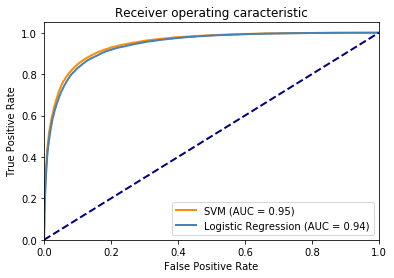

In [0]:
plt.figure()
lw = 2
plt.plot(fpr_svm, tpr_svm, color='darkorange',
         lw=lw, label='SVM (AUC = %0.2f)' % roc_auc_svm)
plt.plot(fpr_log, tpr_log, color='steelblue',
         lw=lw, label='Logistic Regression (AUC = %0.2f)' % roc_auc_log)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating caracteristic')
plt.legend(loc="lower right")
plt.show()


In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title='Normalized confusion matrix',
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=['Positive\n Review','Negative\n Review'], yticklabels=['Positive\n Review','Negative\n Review'],
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Normalized confusion matrix


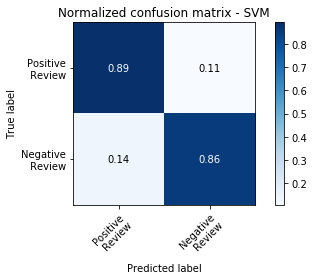

In [0]:
np.set_printoptions(precision=2)
class_names = [0, 1]
plot_confusion_matrix(y_test, y_pred_svm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix - SVM')

plt.show()

Normalized confusion matrix


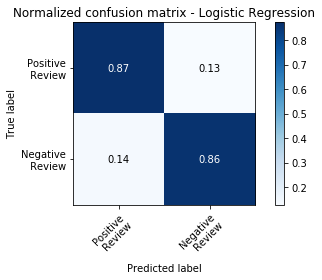

In [0]:
np.set_printoptions(precision=2)
class_names = [0, 1]
plot_confusion_matrix(y_test, y_pred_log, classes=class_names, normalize=True,
                      title='Normalized confusion matrix - Logistic Regression')

plt.show()